In [1]:
########################################
class PMM:

    def __init__(self, g, b, AK, BK, A_hat_K, B_hat_K, d1, d2, D, kern, AA_hat_K, AB_hat_K, BA_hat_K, BB_hat_K): #g, b are functions 
        self.g = g
        self.b = b
        self.AK = AK
        self.BK = BK
        self.A_hat_K = A_hat_K
        self.B_hat_K = B_hat_K
        self.d1 = d1  #domain for pde
        self.d2 = d2
        self.D = D  #domain for boundary 
        self.kern = kern 
        self.AA_hat_K = AA_hat_K
        self.AB_hat_K = AB_hat_K
        self.BA_hat_K = BA_hat_K
        self.BB_hat_K = BB_hat_K

    def X_0A(self, mA):
        return [self.d1 + i*(self.d2 - self.d1)/mA for i in range(1, mA)]
    
    def X_0B(self, mB):
        return [self.D[i] for i in range(0, mB)]

    def g_matrix(self, mA):
        return np.vectorize(self.g)(self.X_0A(mA)).T

    def b_matrix(self, mB):
        return np.vectorize(self.b)(self.X_0B(mB)).T

    def Gram(self, X, Y, func):  #X, T are both list 
        output = np.zeros((len(X), len(Y)))
        for i in range(len(X)):
            for j in range(len(Y)):
                output[i-1][j-1] = func(X[i], Y[j]) 
                
        return output 

    def posterior(self, X, mA, mB):
        L_hat_K = np.hstack((self.Gram(X, self.X_0A(mA), self.A_hat_K), self.Gram(X, self.X_0B(mB), self.B_hat_K)))


        LK = np.vstack((self.Gram(self.X_0A(mA), X, self.AK), self.Gram(self.X_0B(mB), X, self.BK))) #LK 


        LL_hat_K = np.vstack((np.hstack((self.Gram(self.X_0A(mA), self.X_0A(mA), self.AA_hat_K), 
                                self.Gram(self.X_0A(mA), self.X_0B(mB), self.AB_hat_K))), 
                                np.hstack((self.Gram(self.X_0B(mB), self.X_0A(mA), self.BA_hat_K), 
                                self.Gram(self.X_0B(mB), self.X_0B(mB), self.BB_hat_K)))))

        latter = np.hstack((self.g_matrix(mA).T, self.b_matrix(mB).T)).T

        middle = np.linalg.inv(LL_hat_K)

        mean = np.matmul(np.matmul(L_hat_K, middle), latter)
        var = self.Gram(X, X, self.kern)  - np.matmul(np.matmul(L_hat_K, middle), LK)

        return mean, var 


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal

def real_u(x):
    return  (1/ (2* np.pi**2))*((np.sin(np.pi * x))**2)

def Wendland_kern(x1, x2, epsilon = 0.001): #kernel, use Wendland covariance as an example 
        return np.max(1 - np.abs(x1 - x2)/epsilon, 0)**4 * (4*np.abs(x1 - x2)/epsilon + 1)

def gauss_kernel(x1, x2, L=0.25):
    return np.exp(- (x1-x2)**2 / (2* L**2))

def gauss_kernel_derix(x1, x2, L=0.25):
    return np.exp(-(x1-x2)**2 / (2* L**2)) * (-(x1 - x2) / L**2)

def gauss_kernel_deriy(x1, x2, L=0.25):
    return np.exp(-(x1-x2)**2 / (2* L**2)) * ((x1 - x2) / L**2)

def gauss_kernel_derixy(x1, x2, L=0.25):
    return np.exp(-(x1-x2)**2 / (2* L**2)) * (1/ L**4) * (-(x1-x2)**2  + L**2)

def gauss_kernel_derixx(x1, x2, L=0.25): #This is A operator 
    return np.exp(-(x1-x2)**2 / (2* L**2)) * (1/ L**4) * ((x1-x2)**2  - L**2)

def gauss_kernel_deriyy(x1, x2, L=0.25): #This is A_hat operator 
    return gauss_kernel_derixx(x1, x2, L) 

#AA_hat operator
def gauss_kernel_derixxyy(x1, x2, L=0.25):
    return np.exp(-(x1-x2)**2 / (2* L**2)) * (1/ L**8) *(3* (L**4) - 6* (L**2)*((x1-x2)**2) + (x1-x2)**4)

g1 =  lambda x: np.cos(2*np.pi*x)
b1 = lambda x: 0

d1, d2 = 0, 1
D = [0, 1]

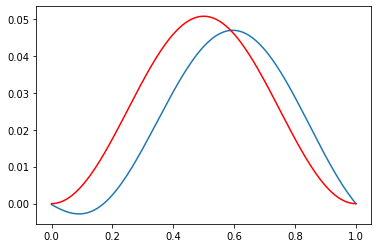

In [3]:
poisson = PMM(g1, b1, gauss_kernel_derixx, gauss_kernel, gauss_kernel_deriyy, gauss_kernel, 0, 1, D, gauss_kernel, gauss_kernel_derixxyy, gauss_kernel_derixx, gauss_kernel_deriyy, gauss_kernel)

N = 200
X = [(1/N)*i for i in range(N)]
mean1, var1 = poisson.posterior(X, 10, 2)

# compare the mean of multivariate normal with true solution 
plt.plot(np.linspace(0, 1, N),  mean1)
plt.plot(np.linspace(0, 1, N), real_u(np.linspace(0, 1, N)), color = 'r')
plt.show()

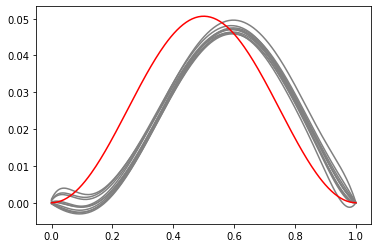

In [4]:
sample = np.random.multivariate_normal(mean1, var1, size=10)
plt.plot(np.linspace(0, 1, N),  sample.T, color = 'grey')
plt.plot(np.linspace(0, 1, N), real_u(np.linspace(0, 1, N)), color = 'r')
plt.show()

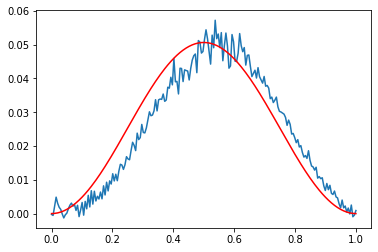

In [5]:
mean2, var2 = poisson.posterior(X, 20, 2)

plt.plot(np.linspace(0, 1,  N),  mean2)
plt.plot(np.linspace(0, 1, N), real_u(np.linspace(0, 1, N)), color = 'r')
plt.show()

<ipython-input-6-ace28e79384a>:1: RuntimeWarning: covariance is not positive-semidefinite.
  sample = np.random.multivariate_normal(mean2, var2, size=10)


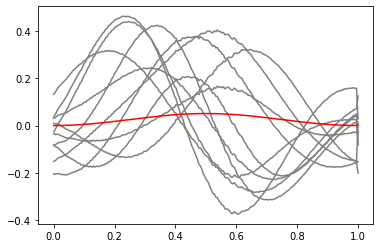

In [6]:
sample = np.random.multivariate_normal(mean2, var2, size=10)
plt.plot(np.linspace(0, 1, N),  sample.T, color = 'grey')
plt.plot(np.linspace(0, 1, N), real_u(np.linspace(0, 1, N)), color = 'r')
plt.show()